https://stephenholiday.com/articles/2011/gender-prediction-with-python/

In [219]:
import pandas as pd
import numpy as np
import itertools
import os
import matplotlib.pyplot as plt
from time import time, ctime
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.metrics import accuracy_score, classification_report, classification, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from helper import plot_confusion_matrix, plot_confusion_matrix2
dim=lambda *x: [i.shape for i in x]

import wordninja

In [220]:
df = pd.read_csv('./users.gender.golden.csv')
print df.shape
print df['fname.gender'].value_counts(dropna=False)
df.head()

(121335, 9)
NaN       71935
male      40389
female     9011
Name: fname.gender, dtype: int64


,user_id,username,freq,male.prob,fname.gender,male.prob2,fname.gender2,Name,pic.gender
0,5.0,billion,2.0,1.0000,male,0.920000,male,NaN,NaN
1,63.0,paddyshyam,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,64.0,ArmenSoft,1.0,1.0000,male,NaN,NaN,NaN,NaN
3,128.0,okbookman,1.0,0.9945,male,0.998834,male,NaN,NaN
4,215.0,revitupmedia,1.0,1.0000,male,NaN,NaN,215_profile.jpg,NaN


In [221]:
pre9=df[(~df['fname.gender'].isnull())][['username','fname.gender']]
print pre9.shape

pre1=df[(~df['fname.gender'].isnull())& abs(df['male.prob']-0.5)>0.4][['username','fname.gender']]
pre1.shape
pre1.head()

(49400, 2)


,username,fname.gender
0,billion,male
2,ArmenSoft,male
3,okbookman,male
4,revitupmedia,male
7,sakshiinfosys,male


In [222]:
pre1['split_words']=pre1['username'].\
apply(lambda x: ''.join([i for i in str(x) if i.isdigit()==False])).\
apply(lambda x: wordninja.split(str(x).lower()))

from genderizer.genderizer import Genderizer
import gender_guesser.detector as gender
d = gender.Detector(case_sensitive=False)

def helper(X):
    tmp = list(map(d.get_gender, X))
    tmp = [i for i in tmp if i!='unknown']
    try:
        tmp[0]
        if len(tmp)>1:
            m=0
            f=0
            for i in tmp:
                if i in ['male','mostly_male','andy']:
                    m+=1
                elif i in ['female','mostly_female']:
                    f+=1
            # change here
            if m>f:
                return 'male'
            else:
                return 'female'
        else:
            if tmp[0] in ['male','mostly_male','andy']:
                    return 'male'
            else:
                return 'female'
    except:
        return 'unknow'
    
pre1['username_split_predict'] = pre1['split_words'].apply(helper)
pre1 = pre1.drop(['split_words'],axis=1)
pre1.tail()

,username,fname.gender,username_split_predict
121328,gewens,male,male
121329,Alexa77,female,female
121330,ilmanen,female,male
121332,xmonika,female,female
121333,lidsoft,male,unknow


In [223]:
def name_count(name):
    arr = np.zeros(52+26*26+3)
    # Iterate each character
    for ind, x in enumerate(name):
        arr[ord(x)-ord('a')] += 1
        arr[ord(x)-ord('a')+26] += ind+1
    # Iterate every 2 characters
    for x in xrange(len(name)-1):
        ind = (ord(name[x])-ord('a'))*26 + (ord(name[x+1])-ord('a')) + 52
        arr[ind] += 1
        # Last character
        arr[-3] = ord(name[-1])-ord('a')
        # Second Last character
        arr[-2] = ord(name[-2])-ord('a')
    # Length of name
    arr[-1] = len(name)
    return arr

In [224]:
52+26*26+3

731

In [225]:
%%time
pre1 =pre1.reset_index(drop=True)

pre1['mock_name']= pre1['username'].apply(lambda x: ''.join([i.lower() for i in str(x) if i.isdigit()==False]))
list_list =np.array(map(name_count, pre1['mock_name']))
print list_list.shape
tmp = pd.DataFrame(data=list_list, columns=['feature_'+str(i) for i in range(731)])
print tmp.shape
tmp.head(1)

(49260, 731)
(49260, 731)
CPU times: user 977 ms, sys: 57 ms, total: 1.03 s
Wall time: 1.03 s


In [226]:
# %%time
# print cross_val_score(RandomForestClassifier(), tmp, pre0['fname.gender'], cv=10)

In [227]:
# name_count('abcdfaa')

In [228]:
# tmp = pd.DataFrame(data=name_count('abcdfaa').reshape(1,-1), columns=['feature_'+str(i) for i in range(731)])
# tmp

In [229]:
pre1.shape

(49260, 4)

In [230]:
pre1.head()

,username,fname.gender,username_split_predict,mock_name
0,billion,male,unknow,billion
1,ArmenSoft,male,male,armensoft
2,okbookman,male,female,okbookman
3,revitupmedia,male,unknow,revitupmedia
4,sakshiinfosys,male,male,sakshiinfosys


In [231]:
# pre0.head()

In [232]:
%%time
def add_features(df):
    
    df['last']= df['username'].str[-1]
    df['last_two']= df['username'].str[-2:]
    df['last_three']= df['username'].str[-3:]
    df['first']= df['username'].str[0]
    df['first2']= df['username'].str[:2]
    df['first3']= df['username'].str[:3]
    df['nchar']= df['username'].apply(lambda x: len(str(x)))
    df['vowels.pct']=df['username'].apply(lambda x: len([i for i in str(x) if i in 'aeiouy'])/float(len(str(x))))
    df['digits.pct']=df['username'].apply(lambda x: sum([i.isdigit() for i in str(x)])/float(len(str(x))))
    df['last_is_vowel'] = df['username'].apply(lambda x: str(x)[-1] in 'aeiouy')
    df['first_is_vowel'] = df['username'].apply(lambda x: str(x)[0] in 'aeiouy')
    df['last_is_digit'] = df['username'].apply(lambda x: str(x)[-1].isdigit())
    df['first_is_digit'] = df['username'].apply(lambda x: str(x)[0].isdigit())
    df['digits.num'] = df['username'].apply(lambda x: sum([i.isdigit() for i in str(x)]))
    df['upper.pct'] = df['username'].apply(lambda x: sum([i.isupper() for i in str(x)]))
    df['first_is_upper'] = df['username'].apply(lambda x: str(x)[0].isupper())
    df.pop('mock_name')
    
    
    

    
pre0=pre1.copy()

add_features(pre0)

pre0 = pd.concat([pre0, tmp], axis=1)

print pre0.shape

(49260, 747)
CPU times: user 547 ms, sys: 53 ms, total: 600 ms
Wall time: 592 ms


In [233]:
pre0.head(1)

,username,fname.gender,username_split_predict,last,last_two,first,first2,vowels.pct,digits.pct,last_is_vowel,...,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,b,bi,0.428571,0.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0


In [234]:
pre0.head()

,username,fname.gender,username_split_predict,last,last_two,first,first2,vowels.pct,digits.pct,last_is_vowel,...,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,b,bi,0.428571,0.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0
1,ArmenSoft,male,male,t,ft,A,Ar,0.222222,0.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,5.0,9.0
2,okbookman,male,female,n,an,o,ok,0.444444,0.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,9.0
3,revitupmedia,male,unknow,a,ia,r,re,0.500000,0.0,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
4,sakshiinfosys,male,male,s,ys,s,sa,0.384615,0.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,24.0,13.0


In [235]:
# pre0.to_csv('./preprocessed.csv', index=False)

In [236]:
print pre0.iloc[:,1].value_counts()
40389.0/(40389+8871)

male      40389
female     8871
Name: fname.gender, dtype: int64


0.8199147381242388

### accuracy if set all male

In [237]:
# print pre0.columns.values
print pre0.columns.values[2:5]
pre0.head()

['username_split_predict' 'last' 'last_two']


,username,fname.gender,username_split_predict,last,last_two,first,first2,vowels.pct,digits.pct,last_is_vowel,...,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,b,bi,0.428571,0.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0
1,ArmenSoft,male,male,t,ft,A,Ar,0.222222,0.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,5.0,9.0
2,okbookman,male,female,n,an,o,ok,0.444444,0.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,9.0
3,revitupmedia,male,unknow,a,ia,r,re,0.500000,0.0,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
4,sakshiinfosys,male,male,s,ys,s,sa,0.384615,0.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,24.0,13.0


In [238]:
pre0.head()

,username,fname.gender,username_split_predict,last,last_two,first,first2,vowels.pct,digits.pct,last_is_vowel,...,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,b,bi,0.428571,0.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0
1,ArmenSoft,male,male,t,ft,A,Ar,0.222222,0.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,5.0,9.0
2,okbookman,male,female,n,an,o,ok,0.444444,0.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,9.0
3,revitupmedia,male,unknow,a,ia,r,re,0.500000,0.0,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
4,sakshiinfosys,male,male,s,ys,s,sa,0.384615,0.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,24.0,13.0


In [239]:
%%time
def label_encode(df, columns):
    for col in columns:
        le = LabelEncoder()
        col_values_unique = list(df[col].unique())
        le_fitted = le.fit(col_values_unique)
 
        col_values = list(df[col].values)
        le.classes_
        col_values_transformed = le.transform(col_values)
        df[col] = col_values_transformed
 
to_be_encoded_cols = pre0.columns.values[2:7]
label_encode(pre0, to_be_encoded_cols)

# pre0 =pre0.drop(['username_split_predict'], axis=1)

CPU times: user 89 ms, sys: 0 ns, total: 89 ms
Wall time: 88 ms


In [240]:
X_train, X_test, y_train, y_test =train_test_split(pre0.iloc[:,2:], pre0.iloc[:,1], test_size=.3, stratify =pre0.iloc[:,1])
print dim(X_train, y_train, X_test, y_test )
X_train.head(1)

[(34482, 745), (34482,), (14778, 745), (14778,)]


,username_split_predict,last,last_two,first,first2,vowels.pct,digits.pct,last_is_vowel,first_is_vowel,last_is_digit,...,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
39206,2,55,999,26,976,0.454545,0.0,False,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,4.0,11.0


In [241]:
# pre0.to_csv('preprocessed.csv',index=False)

In [242]:
# cross_val_score(RandomForestClassifier(), pre0.iloc[:,2:], pre0.iloc[:,1], cv=10)
print y_train.value_counts()

## true labels
print len(y_test)
y_test.value_counts()

male      28272
female     6210
Name: fname.gender, dtype: int64
14778


male      12117
female     2661
Name: fname.gender, dtype: int64

In [243]:
%%time
fr=RandomForestClassifier()
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 3.35 s, sys: 152 ms, total: 3.5 s
Wall time: 3.5 s


0.819935038571
0.820341047503
Confusion matrix, without normalization
[[  432  2229]
 [  426 11691]]


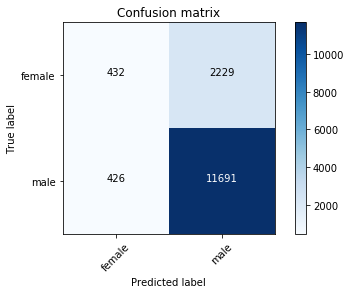

In [244]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [245]:
%%time
fr=RandomForestClassifier(n_estimators=150, min_samples_split=5, n_jobs=24)
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 51.8 s, sys: 257 ms, total: 52 s
Wall time: 4.18 s


0.819935038571
0.831235620517
Confusion matrix, without normalization
[[  193  2468]
 [   26 12091]]


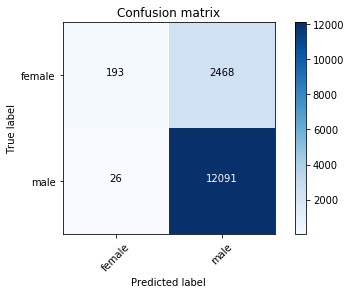

In [246]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [247]:
%%time
fr=RandomForestClassifier(n_estimators=640, min_samples_split=4, n_jobs=24)
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 3min 36s, sys: 739 ms, total: 3min 37s
Wall time: 12 s


0.819935038571
0.833062660712
Confusion matrix, without normalization
[[  220  2441]
 [   26 12091]]


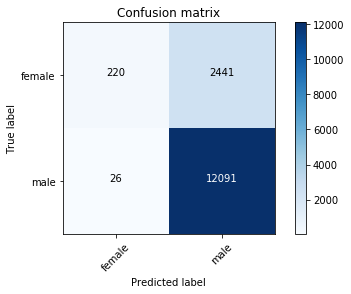

In [248]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [249]:
def plotting(model, df, num):
    forest = model
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]



    # Plot the feature importances of the forest
    plt.figure(figsize=(16,8))
    plt.title("Feature importances")
    plt.barh(range(num), importances[indices][:num],
           color="g", xerr=std[indices][:num], 
            align="center", alpha=.7)

    plt.yticks(range(num), list(df.columns[indices][:num],))
    plt.ylim([-1, num])

    plt.gca().invert_yaxis()

    plt.show()

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(df.shape[1]):
        print("{}. feature {} ({:.2f} %)" .format (f + 1, df.columns[indices[f]], 100*importances[indices[f]]))

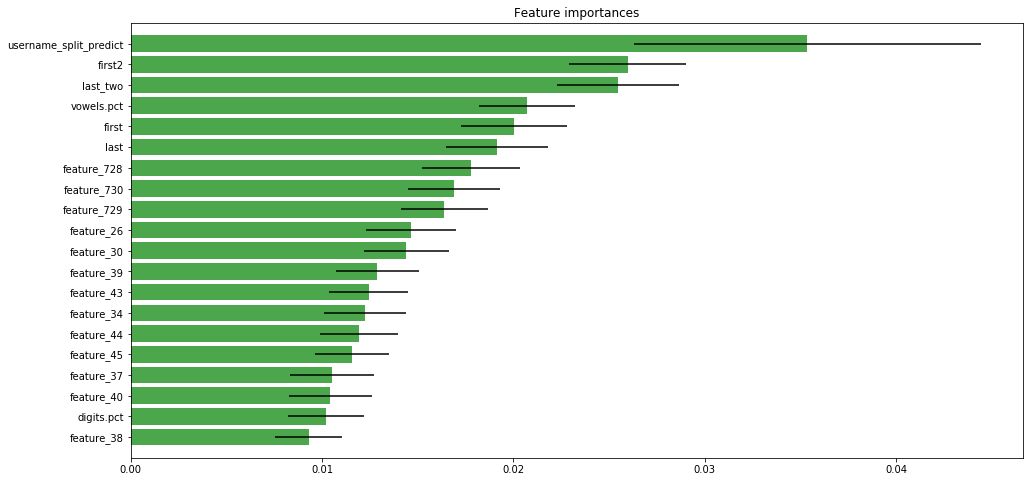

Feature ranking:
1. feature username_split_predict (3.53 %)
2. feature first2 (2.60 %)
3. feature last_two (2.55 %)
4. feature vowels.pct (2.07 %)
5. feature first (2.00 %)
6. feature last (1.91 %)
7. feature feature_728 (1.78 %)
8. feature feature_730 (1.69 %)
9. feature feature_729 (1.64 %)
10. feature feature_26 (1.46 %)
11. feature feature_30 (1.44 %)
12. feature feature_39 (1.29 %)
13. feature feature_43 (1.24 %)
14. feature feature_34 (1.22 %)
15. feature feature_44 (1.19 %)
16. feature feature_45 (1.16 %)
17. feature feature_37 (1.05 %)
18. feature feature_40 (1.04 %)
19. feature digits.pct (1.02 %)
20. feature feature_38 (0.93 %)
21. feature feature_28 (0.91 %)
22. feature feature_29 (0.84 %)
23. feature feature_33 (0.82 %)
24. feature feature_0 (0.77 %)
25. feature digits.num (0.75 %)
26. feature feature_4 (0.75 %)
27. feature feature_27 (0.73 %)
28. feature feature_32 (0.72 %)
29. feature feature_46 (0.70 %)
30. feature feature_36 (0.69 %)
31. feature feature_18 (0.68 %)
32. 

In [250]:
plotting(fr, X_train, 20)

In [164]:
# RandomForestClassifier?

In [251]:
%%time
fr=RandomForestClassifier(n_estimators=200
                          , min_samples_split=6, n_jobs=24, criterion='entropy')
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 1min 3s, sys: 282 ms, total: 1min 4s
Wall time: 4.96 s


0.819935038571
0.831979970226
Confusion matrix, without normalization
[[  205  2456]
 [   27 12090]]


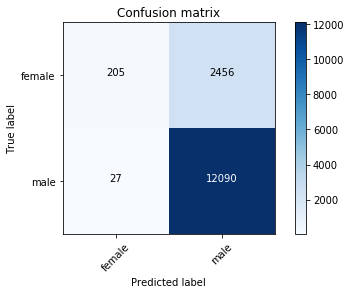

In [252]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

0.819461361483
Confusion matrix, without normalization
[[  120  2541]
 [  127 11990]]


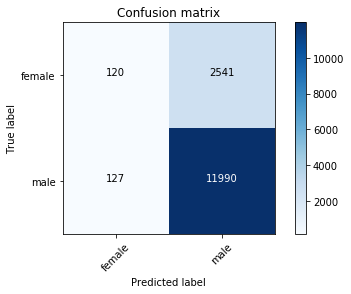

CPU times: user 8.56 s, sys: 2.34 s, total: 10.9 s
Wall time: 8.43 s


In [253]:
%%time
lsvm = LinearSVC()
lsvm.fit(X_train, y_train)
lsvm_pr=lsvm.predict(X_test)
pd.Series(lsvm_pr).value_counts()
print accuracy_score(y_test, lsvm_pr)
plot_confusion_matrix(confusion_matrix(y_test,lsvm_pr), ['female','male'])

### try xgboost

https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

In [255]:
import xgboost as xgb

/home/shj16110/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [256]:
d_train = xgb.DMatrix(X_train, label=y_train.map({'male':1, 'female':0}))
d_test = xgb.DMatrix(X_test, label=y_test.map({'male':1, 'female':0}))

In [257]:
d_train.get_label()

array([ 0.,  1.,  1., ...,  1.,  1.,  1.], dtype=float32)

In [258]:
RANDOM_STATE = 2017
params = {
    'min_child_weight': 0.7,
#     'eta': 0.1,
    'colsample_bytree': 0.7,
    'max_depth': 24,
    'subsample': 0.7,
    'alpha': 0.2,
    'lambda':0.8,
    'gamma': 0.2,
    'silent': 0,
    'learning_rate':0.05,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    'n_jobs':12
    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

In [259]:
def female_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    cof = confusion_matrix(y, tmp)
    g_f_c = cof[0][0]
    b_f_c = cof[1][0]
    r_f_c = cof[0][1]
    target = (g_f_c - 1.1*b_f_c)/float(r_f_c)
    return 'female_acc',target
    

In [260]:
start=time()

clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, 
                verbose_eval=20, feval=xg_eval, maximize=True)
                


'!!! used %.2f s'%(time()-start)

[0]	train-acc:0.850473	test-acc:0.807281
Multiple eval metrics have been passed: 'test-acc' will be used for early stopping.

Will train until test-acc hasn't improved in 100 rounds.
[20]	train-acc:0.867061	test-acc:0.829206
[40]	train-acc:0.88043	test-acc:0.830694
[60]	train-acc:0.897599	test-acc:0.832386
[80]	train-acc:0.918972	test-acc:0.833401
[100]	train-acc:0.933444	test-acc:0.833942
[120]	train-acc:0.949481	test-acc:0.83516
[140]	train-acc:0.962705	test-acc:0.83604
[160]	train-acc:0.973464	test-acc:0.836378
[180]	train-acc:0.981701	test-acc:0.836175
[200]	train-acc:0.987762	test-acc:0.835769
[220]	train-acc:0.991184	test-acc:0.836378
[240]	train-acc:0.993968	test-acc:0.835769
[260]	train-acc:0.996027	test-acc:0.83604
Stopping. Best iteration:
[171]	train-acc:0.978105	test-acc:0.837055



'!!! used 58.69 s'

accuracy 0.835904723237
statistic
male      14172
female      606
dtype: int64
Confusion matrix, without normalization
[[  421  2240]
 [  185 11932]]


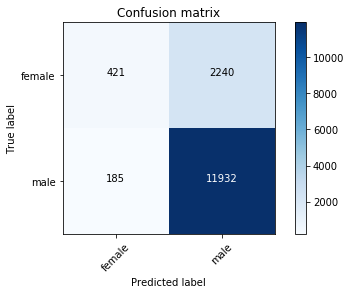

In [261]:
# pd.Series(clf.predict(d_test)).describe()
print 'accuracy',accuracy_score(d_test.get_label(), clf.predict(d_test)>.5)
print 'statistic'
print pd.Series(clf.predict(d_test)>.5).map({1:'male',0:'female'}).value_counts()
plot_confusion_matrix(confusion_matrix(d_test.get_label(),clf.predict(d_test)>.5), ['female','male'])

#### on accuracy 

### tune

In [262]:
RANDOM_STATE = 2017
params = {
    'min_child_weight': 0.7,
#     'eta': 0.1,
    'colsample_bytree': 0.7,
    'max_depth': 24,
    'subsample': 0.7,
    'alpha': 0.2,
    'lambda':0.8,
    'gamma': 0.2,
    'silent': 0,
    'learning_rate':0.05,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    'n_jobs':12
    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

In [263]:
y_train.value_counts()

male      28272
female     6210
Name: fname.gender, dtype: int64

In [264]:
6210.0/28272

0.21965195246179967

In [265]:
RANDOM_STATE = 2017

params = {
    'min_child_weight': 0.8,
#     'eta': 0.1,
    'colsample_bytree': 0.8,
    'max_depth': 28,
    'subsample': 0.8,
    'alpha': 2,
    'lambda':3,
    'gamma': 0.1,
    'silent': 0,
    'learning_rate':0.01,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    'n_jobs':12,
        'max_delta_step ':7,
        'colsample_bylevel ':0.9 ,    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

In [ ]:
start=time()

clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=500, 
                verbose_eval=20, feval=xg_eval, maximize=True)
                


'!!! used %.2f s'%(time()-start)

[0]	train-acc:0.837538	test-acc:0.823589
Multiple eval metrics have been passed: 'test-acc' will be used for early stopping.

Will train until test-acc hasn't improved in 500 rounds.
[20]	train-acc:0.842121	test-acc:0.82677
[40]	train-acc:0.844209	test-acc:0.82704
[60]	train-acc:0.845601	test-acc:0.827582
[80]	train-acc:0.846993	test-acc:0.827988
[100]	train-acc:0.848588	test-acc:0.828191
[120]	train-acc:0.850589	test-acc:0.828597
[140]	train-acc:0.852474	test-acc:0.82907
[160]	train-acc:0.853924	test-acc:0.829544
[180]	train-acc:0.855142	test-acc:0.830085
[200]	train-acc:0.85665	test-acc:0.830085
[220]	train-acc:0.8581	test-acc:0.830424
[240]	train-acc:0.859666	test-acc:0.830356
[260]	train-acc:0.861058	test-acc:0.830762
[280]	train-acc:0.86245	test-acc:0.831236
[300]	train-acc:0.863929	test-acc:0.831506
[320]	train-acc:0.865176	test-acc:0.831912
[340]	train-acc:0.867322	test-acc:0.831845
[360]	train-acc:0.868946	test-acc:0.832115
[380]	train-acc:0.871382	test-acc:0.832589
[400]	train

In [ ]:
# pd.Series(clf.predict(d_test)).describe()
print 'accuracy',accuracy_score(d_test.get_label(), clf.predict(d_test)>.5)
print 'statistic'
print pd.Series(clf.predict(d_test)>.5).map({1:'male',0:'female'}).value_counts()
plot_confusion_matrix(confusion_matrix(d_test.get_label(),clf.predict(d_test)>.5), ['female','male'])

In [248]:
f_ip = pd.DataFrame(clf.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
f_ip.head(10)

,feature,importance
480,last_three,75696
136,last_two,59834
276,first3,59419
357,vowels.pct,48883
415,last,37114
251,first,32742
508,feature_728,27695
418,nchar,27236
507,feature_729,26850
519,feature_30,26037


In [257]:
pd.DataFrame.plot?

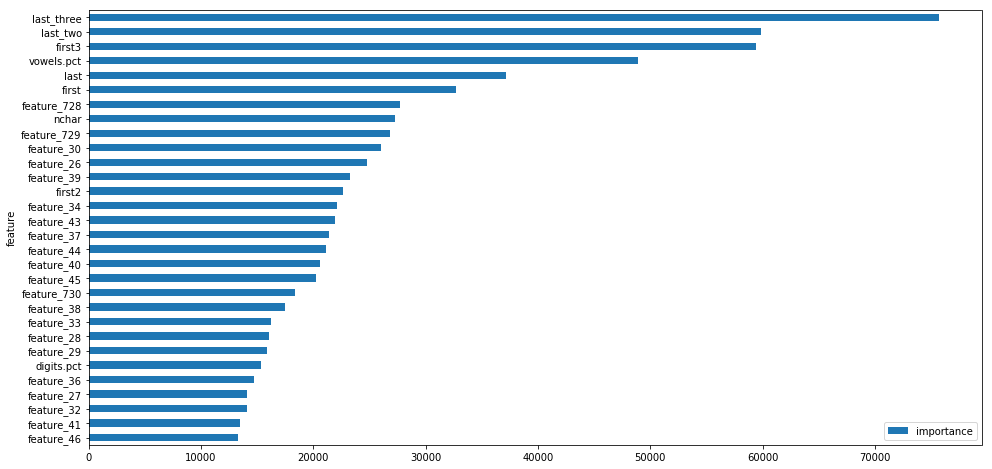

In [273]:
f_ip.head(30).iloc[::-1].set_index('feature').plot(kind='barh', figsize=(16,8))
plt.show()

In [120]:
pre0 = pre1.copy()
pre0.head(3)

,username,fname.gender,username_split_predict,mock_name
0,billion,male,unknow,billion
1,ArmenSoft,male,male,armensoft
2,okbookman,male,male,okbookman


### other sklearn models

In [270]:
# %%time
# lsvm = LinearSVC()
# lsvm.fit(X_train, y_train)
# lsvm_pr=lsvm.predict(X_test)
# pd.Series(lsvm_pr).value_counts()
# print accuracy_score(y_test, lsvm_pr)
# plot_confusion_matrix(confusion_matrix(y_test,lsvm_pr), ['female','male'])

In [110]:
# cross_val_score(SVC(), pre0.iloc[:,2:], pre0.iloc[:,1], cv=10)

In [140]:
# svm = SVC()
# svm

In [141]:
# %%time
# # svm.fit(X_train, y_train)

In [142]:
# from sklearn.neural_network import MLPClassifier

In [143]:
# neur = MLPClassifier(verbose=True, learning_rate='adaptive', hidden_layer_sizes=(200,20,1))
# neur

https://wiki.hpc.uconn.edu/index.php/GPU_Guide

In [145]:
# %%time
# neur.fit(X_train, y_train)
# neur_prd = neur.predict(X_test)

In [146]:
# pd.Series(neur_prd).value_counts()

In [147]:
# accuracy_score(y_test,neur_prd)

In [148]:
# plot_confusion_matrix(confusion_matrix(y_test,neur_prd), ['female','male'])

In [156]:
# %%time
# pred = svm.predict(X_test)
# pred.shape

In [157]:
# pd.Series(pred).value_counts()

In [158]:
# accuracy_score(y_test, pred)

In [159]:
# confusion_matrix(y_test,pred)

In [161]:
# plot_confusion_matrix(confusion_matrix(y_test,pred), ['female','male'])


In [149]:
# from sklearn.naive_bayes import BernoulliNB

In [150]:
# nb = BernoulliNB()
# nb

In [162]:
# %%time
# nb.fit(X_train, y_train)
# nb_pd=nb.predict(X_test)
# print pd.Series(nb_pd).value_counts()